Dataset used has incomplete results from 2023 onwards.

# Libraries used
- `duckdb`: Wrangling data with SQL
- `matplotlib`: Plotting graphs

I used `duckdb` instead of the typical choice of `pandas` because I am more comfortable with SQL and EDA project is the perfect oppurtunity to test new tools out.

In [1]:
import duckdb
import matplotlib.pyplot as plt
duckdb.sql("IMPORT DATABASE 'f1db'")
plt.style.use('dark_background')

# Where do pole-sitters end up ?

What's the probability that a pole-sitter can snatch a podium? Lets find out!

In [2]:
pole_results = duckdb.sql("SELECT position FROM results WHERE grid = 1 AND POSITION <> '\\N';").fetchall()
pole_results = list(map(lambda r: int(r[0]), pole_results))

min_result, max_result,avg_result = min(pole_results), max(pole_results), sum(pole_results)/len(pole_results)

In [3]:
min_result, max_result, int(avg_result)

(1, 21, 2)

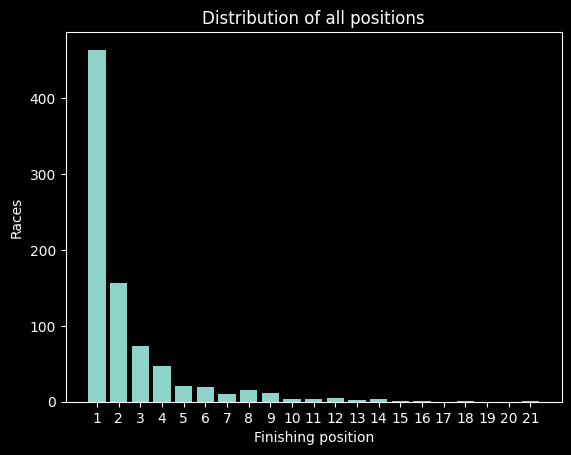

In [4]:
x = range(min_result, max_result+1)

res_count = dict([(idx, 0) for idx in x])
for res in pole_results:
    res_count[res] += 1
y = []
for key in sorted(res_count.keys()):
    y.append(res_count[key])
plt.title("Distribution of all positions")
plt.xticks(x,x)
plt.xlabel("Finishing position")
plt.ylabel("Races")
_ = plt.bar(x,y)

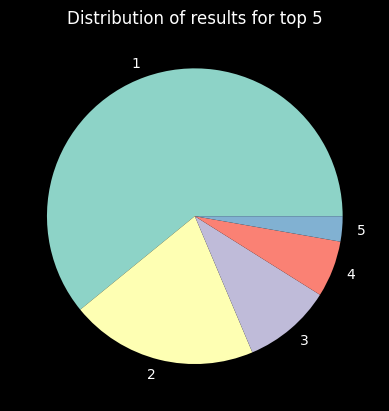

In [5]:
# First 5 pos in a pie chart

first_five = y[0:5]
plt.title("Distribution of results for top 5")
_ = plt.pie(first_five, labels = range(1,6))

From the above analysis, we can see that there is a relatively high chance a pole-sitter can end up on the podium, and a good enough chance that the pole-sitter can get on the top step of the podium (ie, win)

# Fastest laptimes

> NOTE: The dataset used does *not* specify if testing laps are also included.

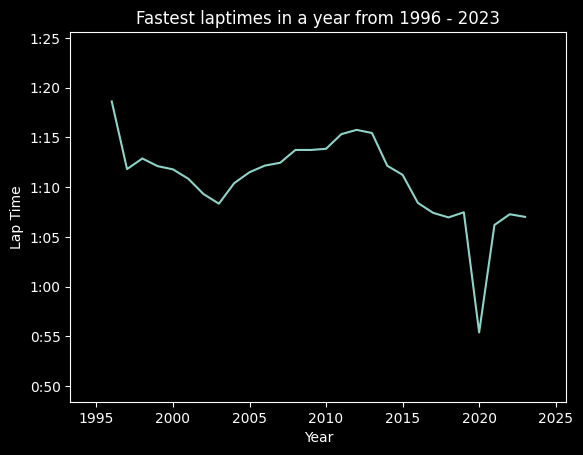

In [6]:
# Fastest laptimes from 1996-2023

def secs_to_mins(s):
    mins = int(s // 60)
    secs = int(s % 60)
    return f'{mins:01d}:{secs:02d}'

year_laptimes = duckdb.sql("SELECT r.year, MIN(l.milliseconds) FROM races r JOIN lap_times l ON (l.raceId = r.raceId) GROUP BY r.year").fetchall()
x = list(map(lambda yl: yl[0], year_laptimes))
y = list(map(lambda yl: yl[1]/1000, year_laptimes))

plt.title(f'Fastest laptimes in a year from {min(x)} - {max(x)}')
plt.xlabel("Year")
plt.ylabel("Lap Time")
plt.margins(.1,.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_: secs_to_mins(y)))
plt.plot(x,y)


We can see the laptimes gradually decrease till 2004, increasing a bit till 2012 and then consitently decreasing.

The dataset shows the fastest lap to be done by RUS in the 2020 Sakhir Grand Prix

# Drivers that have raced during the 2021 F1 Season

Some drivers did not stay till the end of the championship.

In [7]:
# Drivers that raced from 2020-present

duckdb.sql("""
SELECT 
    code,
    (forename || ' ' || surname) AS 'Driver Name'
FROM drivers 
WHERE
    driverId IN (
        SELECT DISTINCT(results.driverId) 
        FROM races
            JOIN results ON (results.raceId = races.raceId)
        WHERE races.year = 2021
    )
ORDER BY code
;
""").show()

┌─────────┬────────────────────┐
│  code   │    Driver Name     │
│ varchar │      varchar       │
├─────────┼────────────────────┤
│ ALO     │ Fernando Alonso    │
│ BOT     │ Valtteri Bottas    │
│ GAS     │ Pierre Gasly       │
│ GIO     │ Antonio Giovinazzi │
│ HAM     │ Lewis Hamilton     │
│ KUB     │ Robert Kubica      │
│ LAT     │ Nicholas Latifi    │
│ LEC     │ Charles Leclerc    │
│ MAZ     │ Nikita Mazepin     │
│ MSC     │ Mick Schumacher    │
│ NOR     │ Lando Norris       │
│ OCO     │ Esteban Ocon       │
│ PER     │ Sergio Pérez       │
│ RAI     │ Kimi Räikkönen     │
│ RIC     │ Daniel Ricciardo   │
│ RUS     │ George Russell     │
│ SAI     │ Carlos Sainz       │
│ STR     │ Lance Stroll       │
│ TSU     │ Yuki Tsunoda       │
│ VER     │ Max Verstappen     │
│ VET     │ Sebastian Vettel   │
├─────────┴────────────────────┤
│ 21 rows            2 columns │
└──────────────────────────────┘



## Home races of the 2021 drivers

Home races motivate the drivers and constructor to give it thier best on the race day (not saying they don't do thier best on other races, but the extra motivation certainly helps)

In [8]:
duckdb.sql("""
-- Display the full name of the driver, the list of circuits, and the country
-- A driver only has 1 nationality, thus only one country
SELECT 
    (d.forename || ' ' || d.surname) AS Driver,
    LIST(c.name) AS Circuit,
    ANY_VALUE(c.country) AS Country
FROM circuits c, drivers d 
WHERE
    -- Convert nationality of driver to country of circuits
    c.country = (SELECT country FROM country_nationality cn WHERE TRIM(cn.nationality) = d.nationality) 
    -- Filter out the drivers who didn't race in 2021
    AND d.driverId IN (
        SELECT driverId FROM drivers WHERE driverId IN
            (SELECT DISTINCT(results.driverId) FROM races JOIN results ON (results.raceId = races.raceId)  WHERE races.year = 2021)
    )
GROUP BY Driver
ORDER BY Driver;
""").show()


┌────────────────────┬───────────────────────────────────────────────────────────────────────────────────┬─────────────┐
│       Driver       │                                      Circuit                                      │   Country   │
│      varchar       │                                     varchar[]                                     │   varchar   │
├────────────────────┼───────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ Antonio Giovinazzi │ [Autodromo Nazionale di Monza, Autodromo Enzo e Dino Ferrari, Pescara Circuit, …  │ Italy       │
│ Carlos Sainz       │ [Valencia Street Circuit, Jarama, Circuit de Pedralbes, Circuit de Barcelona-Ca…  │ Spain       │
│ Charles Leclerc    │ [Circuit de Monaco]                                                               │ Monaco      │
│ Daniel Ricciardo   │ [Adelaide Street Circuit, Albert Park Grand Prix Circuit]                         │ Australia   │
│ Esteban Ocon       │ [Circuit 

# Home races for constructors who have raced from 2010

```mysql
-- Display the name of the constructor, the list of circuits, and the country
-- A constructor only has 1 nationality, thus only one country
SELECT 
    d.name AS Constructor,
    LIST(c.name) AS Circuit,
    ANY_VALUE(c.country) AS Country
FROM circuits c, constructors d
WHERE
    -- Convert nationality of constructor to country of circuits
    c.country = (SELECT country FROM country_nationality cn WHERE TRIM(cn.nationality) = d.nationality) 
    -- Filter out the constructor who didn't race since 2010
    AND d.constructorId IN (
        SELECT constructorId FROM constructors WHERE constructorId IN
            (SELECT DISTINCT(results.constructorId) FROM races JOIN results ON (results.raceId = races.raceId)  WHERE races.year > 2010)
    )
GROUP BY Constructor
ORDER BY Constructor;
```

In [9]:
duckdb.sql("""
-- Display the name of the constructor, the list of circuits, and the country
-- A constructor only has 1 nationality, thus only one country
SELECT 
    d.name AS Constructor,
    LIST(c.name) AS Circuit,
    ANY_VALUE(c.country) AS Country
FROM circuits c, constructors d
WHERE
    -- Convert nationality of constructor to country of circuits
    c.country = (SELECT country FROM country_nationality cn WHERE TRIM(cn.nationality) = d.nationality) 
    -- Filter out the constructor who didn't race since 2010
    AND d.constructorId IN (
        SELECT constructorId FROM constructors WHERE constructorId IN
            (SELECT DISTINCT(results.constructorId) FROM races JOIN results ON (results.raceId = races.raceId)  WHERE races.year > 2010)
    )
GROUP BY Constructor
ORDER BY Constructor;
""").show()

┌────────────────┬───────────────────────────────────────────────────────────────────────────────────────┬─────────────┐
│  Constructor   │                                        Circuit                                        │   Country   │
│    varchar     │                                       varchar[]                                       │   varchar   │
├────────────────┼───────────────────────────────────────────────────────────────────────────────────────┼─────────────┤
│ Alfa Romeo     │ [Circuit Bremgarten]                                                                  │ Switzerland │
│ AlphaTauri     │ [Autodromo Nazionale di Monza, Autodromo Enzo e Dino Ferrari, Pescara Circuit, Auto…  │ Italy       │
│ Alpine F1 Team │ [Circuit de Nevers Magny-Cours, Circuit Paul Ricard, Dijon-Prenois, Charade Circuit…  │ France      │
│ Aston Martin   │ [Silverstone Circuit, Donington Park, Brands Hatch, Aintree]                          │ UK          │
│ Caterham       │ [Sepang Inter

# No. of races in a year

Some of the older drivers on the grid complain that there are too many races on the grid right now. (which is kind of true, travelling could get exhausting) Let's take a look at the historic trends

<BarContainer object of 74 artists>

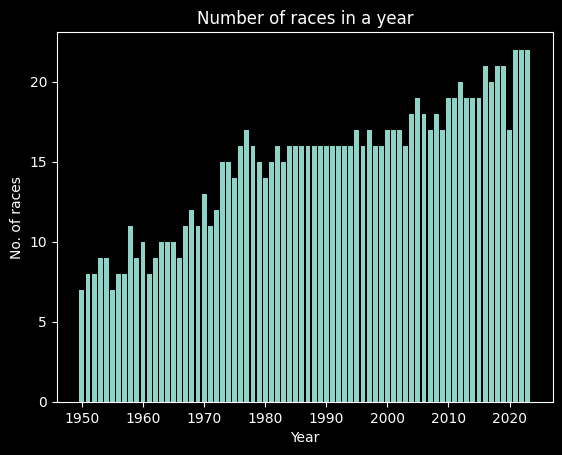

In [10]:
res = duckdb.sql("SELECT year, COUNT(*) FROM races GROUP BY year ORDER BY year;").fetchall()
x = list(map(lambda r: r[0], res))
y = list(map(lambda r: r[1], res))

plt.title("Number of races in a year")
plt.xlabel("Year")
plt.ylabel("No. of races")
plt.bar(x,y)

There is a noticable trend of increasing amount of races as the years go by, with a noticable dip during the 2020 COVID season

# Sprint races

## How many took place in the past few years ?

In [11]:
duckdb.sql("SELECT year, COUNT(*) AS 'No. of sprint races' FROM races WHERE sprint_date <> '\\N' GROUP BY year;").show()

┌───────┬─────────────────────┐
│ year  │ No. of sprint races │
│ int64 │        int64        │
├───────┼─────────────────────┤
│  2021 │                   3 │
│  2022 │                   3 │
│  2023 │                   6 │
└───────┴─────────────────────┘



## Who won the sprints?

```mysql
SELECT 
    year AS Year,
    races.name AS Race,
    (drivers.forename || ' ' || drivers.surname) AS Driver, 
    constructors.name AS Constructor 
    FROM results 
        JOIN constructors ON (results.constructorId = constructors.constructorId)
        JOIN drivers ON (results.driverId = drivers.driverId)
        JOIN races ON (results.raceId = races.raceId)
WHERE 
    position = '1'
    AND results.raceId IN (SELECT races.raceId FROM races WHERE sprint_date <> '\\N')
ORDER BY year;
```

In [12]:
duckdb.sql("""
SELECT 
    year AS Year,
    races.name AS Race,
    (drivers.forename || ' ' || drivers.surname) AS Driver, 
    constructors.name AS Constructor 
    FROM results 
        JOIN constructors ON (results.constructorId = constructors.constructorId)
        JOIN drivers ON (results.driverId = drivers.driverId)
        JOIN races ON (results.raceId = races.raceId)
WHERE 
    position = '1'
    AND results.raceId IN (SELECT races.raceId FROM races WHERE sprint_date <> '\\N')
ORDER BY year;
""").show()


┌───────┬───────────────────────────┬──────────────────┬─────────────┐
│ Year  │           Race            │      Driver      │ Constructor │
│ int64 │          varchar          │     varchar      │   varchar   │
├───────┼───────────────────────────┼──────────────────┼─────────────┤
│  2021 │ British Grand Prix        │ Lewis Hamilton   │ Mercedes    │
│  2021 │ Italian Grand Prix        │ Daniel Ricciardo │ McLaren     │
│  2021 │ São Paulo Grand Prix      │ Lewis Hamilton   │ Mercedes    │
│  2022 │ Emilia Romagna Grand Prix │ Max Verstappen   │ Red Bull    │
│  2022 │ Austrian Grand Prix       │ Charles Leclerc  │ Ferrari     │
│  2022 │ Brazilian Grand Prix      │ George Russell   │ Mercedes    │
│  2023 │ Azerbaijan Grand Prix     │ Sergio Pérez     │ Red Bull    │
│  2023 │ Austrian Grand Prix       │ Max Verstappen   │ Red Bull    │
│  2023 │ Belgian Grand Prix        │ Max Verstappen   │ Red Bull    │
└───────┴───────────────────────────┴──────────────────┴─────────────┘



# Pit stops in F1

They are REALLY fast. What's the trend with the fastest pit-stops over the years ?

> This takes into account the whole pitstop. Not just the time took in changing the tyres.

In [13]:
# Fastest pit stop speeds over the years for different constructors

result = duckdb.sql("""
SELECT 
    year,
    constructors.name,
    MIN(pit_stops.milliseconds)/1000 AS 'Min Seconds',
    AVG(pit_stops.milliseconds)/1000 AS 'Avg Seconds',
    MAX(pit_stops.milliseconds)/1000 AS 'Max Seconds'
FROM pit_stops 
    JOIN races ON (races.raceId = pit_stops.raceId)
    JOIN drivers ON (pit_stops.driverId = drivers.driverId)
    JOIN results ON (results.raceId = pit_stops.raceId AND drivers.driverId = results.driverId)
    JOIN constructors ON (results.constructorId = constructors.constructorId)
WHERE constructors.name IN ('Williams', 'Mercedes', 'Red Bull', 'Ferrari')
GROUP BY year, constructors.name
ORDER BY year, MIN(pit_stops.milliseconds);
""")
res = result.fetchall()

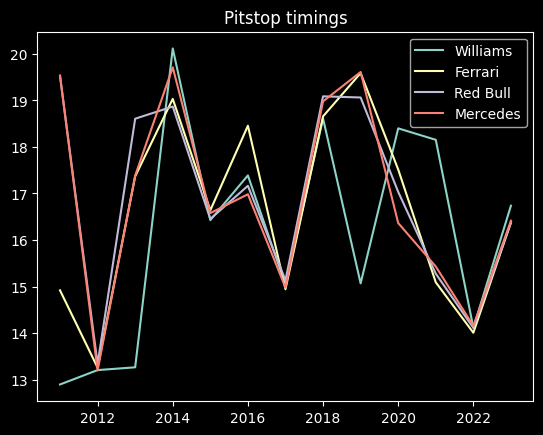

In [14]:
constructors = {}
for (_, name, _, _, _) in res:
    constructors[name] = []
    
for (year, name, min_s, avg_s, max_s) in res:
    constructors[name].append((year,min_s,avg_s, max_s))

for c in constructors.keys():
    x = []
    y = []

    for (year, min_s, _, _) in constructors[c]:
        x.append(year)
        y.append(min_s)
        

    plt.plot(x,y,label = c)
plt.legend(constructors.keys())
_ = plt.title("Pitstop timings")

Not much variation. Everybody seems to be on the same pace.

# Battles

There were some close battles. 2016, 2021 come to mind. Visualise how close they were!

> NOTE: Change the `year` variable and run the cells to see the visuals

In [15]:
# Visualisation of driver points as for a given season

year = 2016

last_race_of_year = duckdb.execute("""
SELECT raceId FROM races WHERE 
    round = (SELECT MAX(round) FROM races WHERE year = $1) 
    AND year = $1
""", [year]).fetchone()[0]

top_10_drivers = duckdb.execute("""
SELECT drivers.code
FROM driver_standings
    JOIN drivers ON (drivers.driverId = driver_standings.driverId)
WHERE raceId = ?
ORDER BY points DESC
LIMIT 10
""", [last_race_of_year]).fetchall()
top_10_drivers = list(map(lambda t: t[0], top_10_drivers))
top_10_drivers

['ROS', 'HAM', 'RIC', 'VET', 'VER', 'RAI', 'PER', 'BOT', 'HUL', 'ALO']

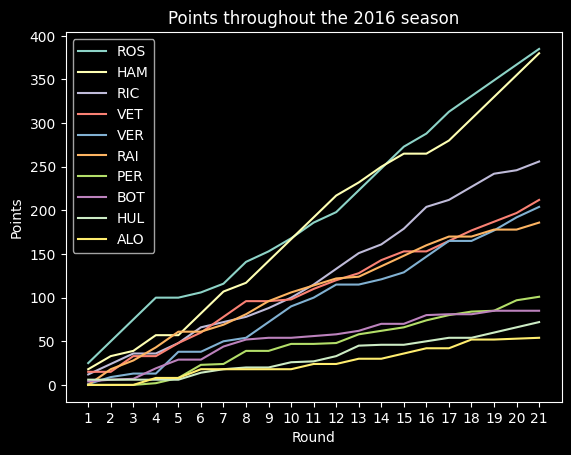

In [16]:
res = duckdb.execute("""
SELECT driver_standings.raceId, races.round, drivers.code, points 
FROM driver_standings 
    JOIN drivers ON (drivers.driverId = driver_standings.driverId) 
    JOIN races ON (driver_standings.raceId = races.raceId)
WHERE 
    driver_standings.raceId IN
        (SELECT races.raceId from races WHERE year = ?) 
    AND list_contains(?, drivers.code)
ORDER BY races.round
;
""",[year,top_10_drivers]).fetchall()

drivers = {}
for driver_code in set(map(lambda r:r[2], res)):
    drivers[driver_code] = []

for (raceId, round, driverCode, points) in res:
    drivers[driverCode].append((round, points))

labels = []
for (driverCode, entries) in sorted(drivers.items(), key = lambda i: top_10_drivers.index(i[0])):
    x = []
    y = []
    for (round, points) in entries:
        x.append(round)
        y.append(points)
    labels.append(driverCode)
    plt.plot(x,y,label = driverCode)

plt.xticks(x,x)

plt.xlabel("Round")
plt.ylabel("Points")
plt.legend(labels)
_ = plt.title(f"Points throughout the {year} season")

# Driver races over the years

People take breaks (MSC, ALO and RAI for ex.)

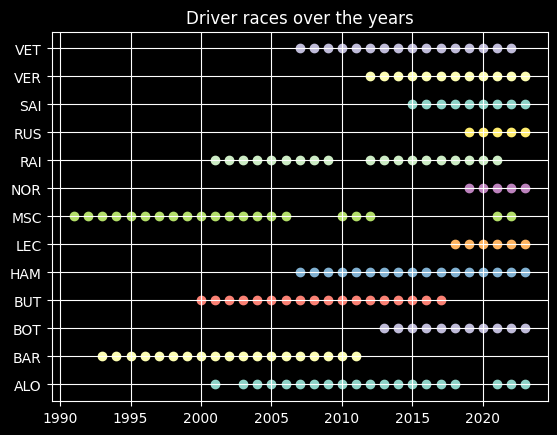

In [17]:
# Drivers of interest
doi = ['ALO', 'VET', 'VER', 'MSC', 'BUT', 'BAR', 'NOR', 'LEC', 'SAI', 'BOT', 'RUS', 'RAI', 'HAM']

res = duckdb.execute("""
SELECT LIST(DISTINCT year), drivers.code
FROM driver_standings 
    JOIN drivers ON (driver_standings.driverId = drivers.driverId)
    JOIN races ON (driver_standings.raceId = races.raceId)
WHERE list_contains($1, drivers.code)
GROUP BY drivers.code
ORDER BY drivers.code
""", [doi]).fetchall()
plt.grid()
for (years, driverCode) in res:
    plt.scatter(
        years,
        [driverCode] * len(years),    
    )
_ = plt.title("Driver races over the years")

# Dominance

See which seasons were dominated by one driver

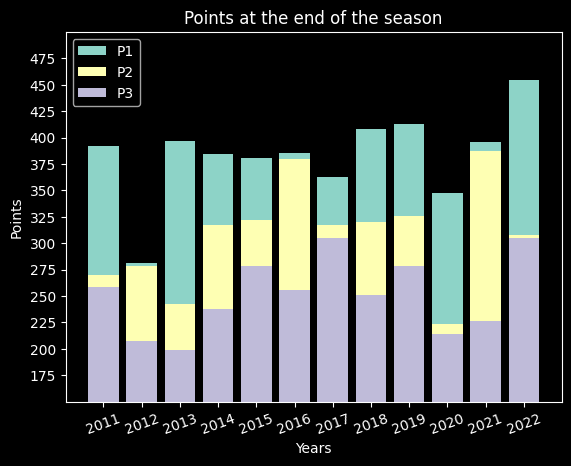

In [18]:
res = duckdb.sql("""

SELECT 
    ANY_VALUE(year),
    list_reverse_sort(LIST(points))[0:3] AS "Top 3 Points" 
FROM driver_standings
    JOIN races ON (driver_standings.raceId = races.raceId)
WHERE
    driver_standings.raceId IN (
        select races.raceId 
        FROM races
            JOIN 
                (SELECT year, MAX(round) AS 'round' FROM races GROUP BY year) yr 
            ON (yr.year = races.year
                    AND yr.round = races.round)
        ORDER BY races.year
    )
    AND year > 2010
GROUP BY driver_standings.raceId
;
""").fetchall()
p1s = []
p2s = []
p3s = []
pts = []
for (year, (p1, p2, p3)) in res:
    p1s.append((year, p1))
    p2s.append((year, p2))
    p3s.append((year, p3))
    pts.extend((p1,p2,p3))

min_pt = min(pts)
for ar in [p1s,p2s,p3s]:
    x = list(map(lambda r: r[0], ar))
    y = list(map(lambda r: r[1], ar))

    plt.bar(x,y)
plt.ylim(150, 500)
plt.yticks(range(175, 500, 25))
plt.xticks(range(2011, 2023), rotation =20)
plt.legend(["P1", "P2", "P3"])
plt.xlabel("Years")
plt.ylabel("Points")
_ = plt.title("Points at the end of the season")

The 2012, 2016 and 2021 season were quite close for the world championship. 